In [2]:
!pip install gdrive_dataset
!pip install numpy
!pip install transformers
!pip install torchmetrics
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 15.3 MB/s eta 0:00:00


In [8]:
from gdrivedataset import loader
import os
from gdrivedataset import loader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [5]:
!wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000327/data/20240827234036/code.tar.gz
# 다운로드한 파일의 압축 해제
!tar -xzvf code.tar.gz
# 압축 해제된 폴더의 내용 확인 (필요에 따라 수정)
!ls
#베이스라인코드

--2024-09-24 10:58:41--  https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000327/data/20240827234036/code.tar.gz
Resolving aistages-api-public-prod.s3.amazonaws.com (aistages-api-public-prod.s3.amazonaws.com)... 52.219.56.131, 52.219.206.35, 52.219.202.47, ...
Connecting to aistages-api-public-prod.s3.amazonaws.com (aistages-api-public-prod.s3.amazonaws.com)|52.219.56.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3085 (3.0K) [binary/octet-stream]
Saving to: ‘code.tar.gz’

code.tar.gz         100%[===================>]   3.01K  --.-KB/s    in 0s      

2024-09-24 10:58:41 (13.1 MB/s) - ‘code.tar.gz’ saved [3085/3085]

./code/
./code/inference.py
./code/requirements.txt
./code/train.py
code  code.tar.gz  data.tar.gz	dev.csv  sample_data  sample_submission.csv  test.csv  train.csv


In [6]:
!wget https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000327/data/data.tar.gz
# 아래 명령어로 압축을 해제해주세요
!tar -zxvf data.tar.gz
#데이터코드

--2024-09-24 10:58:44--  https://aistages-api-public-prod.s3.amazonaws.com/app/Competitions/000327/data/data.tar.gz
Resolving aistages-api-public-prod.s3.amazonaws.com (aistages-api-public-prod.s3.amazonaws.com)... 52.219.56.131, 52.219.206.35, 52.219.202.47, ...
Connecting to aistages-api-public-prod.s3.amazonaws.com (aistages-api-public-prod.s3.amazonaws.com)|52.219.56.131|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 585582 (572K) [application/x-gzip]
Saving to: ‘data.tar.gz.1’

data.tar.gz.1       100%[===================>] 571.86K   962KB/s    in 0.6s    

2024-09-24 10:58:45 (962 KB/s) - ‘data.tar.gz.1’ saved [585582/585582]

._.
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.macl'
./
./._test.csv
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
./test.csv
./._dev.csv
tar: Ignoring unknown extended header

In [9]:
data_train = pd.read_csv("/content/train.csv")
data_dev = pd.read_csv("/content/dev.csv")

In [10]:
import pandas as pd

def swap_sentence(df: pd.DataFrame) -> pd.DataFrame:
    """Sentence1과 Sentence2를 Swap하는 함수"""
    df_swapped = df.copy()

    # 조건에 맞는 데이터만 선택
    mask = ((df['label'] >= 0.5) & (df['label'] < 3.5)) | ((df['label'] >= 4.5) & (df['label'] < 5))
    df_swapped.loc[mask, ['sentence_1', 'sentence_2']] = df_swapped.loc[mask, ['sentence_2', 'sentence_1']].values

    return df_swapped

# Random Swap 적용
data_swapped = swap_sentence(data_train)

# label이 0인 값을 제거
data_swapped_nonzero = data_swapped[data_swapped['label'] != 0.0]

# 데이터 합치기
combined_data = pd.concat([data_train, data_swapped_nonzero], ignore_index=True)

# 결과 출력
print(f"원본 데이터 수: {data_train.shape[0]}")
print(f"스왑된 데이터 수 (label 0.0 제거): {data_swapped_nonzero.shape[0]}")
print(f"합친 데이터 수: {combined_data.shape[0]}")

#--------------------------------------------------------------------------
#간소화 시킨 코드입니다

원본 데이터 수: 9324
스왑된 데이터 수 (label 0.0 제거): 7205
합친 데이터 수: 16529


In [ ]:
#아래는 swap 하면서 확인했던 과정들 입니다

In [ ]:
data_train.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [ ]:
import random

def swap_sentence(df: pd.DataFrame) -> pd.DataFrame:
    """Sentence1과 Sentence2를 Swap하는 함수"""
    df_swapped = df.copy()

    # 조건에 맞는 데이터만 선택
    mask = ((df['label'] >= 0.5) & (df['label'] < 3.5)) | ((df['label'] >= 4.5) & (df['label'] < 5))
    df_swapped.loc[mask, 'sentence_1'] = df['sentence_2']
    df_swapped.loc[mask, 'sentence_2'] = df['sentence_1']

    return df_swapped


In [ ]:
data_train.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,"반전도 있고,사랑도 있고재미도있네요.",2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약조건 변경해주세요.,주택청약 무주택기준 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,입사후 처음 대면으로 만나 반가웠습니다.,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [ ]:
# Random Swap 적용
data_swapped = swap_sentence(data_train)
# 위치 바뀐
data_swapped.head()

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"반전도 있고,사랑도 있고재미도있네요.",스릴도있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약 무주택기준 변경해주세요.,주택청약조건 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,화상으로만 보다가 리얼로 만나니 정말 반가웠습니다.,입사후 처음 대면으로 만나 반가웠습니다.,3.0,1.0
4,boostcamp-sts-v1-train-004,slack-sampled,뿌듯뿌듯 하네요!!,꼬옥 실제로 한번 뵈어요 뿌뿌뿌~!~!,0.0,0.0


In [ ]:
# 원본 데이터 수
original_data_count = data_swapped.shape[0]

# label이 0인 값을 제거
data_swapped_nonzero = data_swapped[data_swapped['label'] != 0.0]

# 스왑된 데이터 수 (0인 값 제거 후)
data_swapped_nonzero.head(60)

,id,source,sentence_1,sentence_2,label,binary-label
0,boostcamp-sts-v1-train-000,nsmc-sampled,"반전도 있고, 사랑도 있고 재미도 있네요.",스릴도 있고 반전도 있고 여느 한국영화 쓰레기들하고는 차원이 다르네요~,2.2,0.0
1,boostcamp-sts-v1-train-001,slack-rtt,앗 제가 접근 권한이 없다고 뜹니다;;,"오, 액세스 권한이 없다고 합니다.",4.2,1.0
2,boostcamp-sts-v1-train-002,petition-sampled,주택청약 무주택기준 변경해주세요.,주택청약 조건 변경해주세요.,2.4,0.0
3,boostcamp-sts-v1-train-003,slack-sampled,화상으로만 보다 가 리얼로 만나니 정말 반가웠습니다.,입사 후 처음 대면으로 만나 반가웠습니다.,3.0,1.0
5,boostcamp-sts-v1-train-005,nsmc-rtt,오 마이 갓 지저스 스크론 이스트 팬,오마이가 뜨지져 스크롸이 스트휏,2.6,1.0
6,boostcamp-sts-v1-train-006,slack-rtt,전 암만 찍어도 까만 하늘.. ㅠㅠ,암만 찍어도 하늘은 까맣다.. ㅠㅠ,3.6,1.0
7,boostcamp-sts-v1-train-007,nsmc-sampled,이렇게 지 겨운 공포영화는 처음..,이렇게 귀여운 쥐들은 처음이네요. ㅎㅎㅎ,0.6,0.0
8,boostcamp-sts-v1-train-008,petition-sampled,미세먼지 해결이 가장 시급한 문제입니다!,가장 시급한 것이 신생아실 관리입니다!!,0.4,0.0
9,boostcamp-sts-v1-train-009,petition-sampled,크림하우스 환불 조치해주세요.,크림하우스 환불 조치할 수 있도록 해주세여,4.2,1.0
10,boostcamp-sts-v1-train-010,slack-rtt,책에서 꺼내야겠어요!,그 책부터 언능 꺼내봐야 겠어요!,2.4,0.0


In [ ]:
swapped_count = data_swapped_nonzero.shape[0]
# 결과 확인
print(f"스왑된 데이터 수 (label 0.0 제거?): {swapped_count}")

스왑된 데이터 수 (label 0.0 제거?): 7205


In [ ]:
# 스왑된 데이터 수
swapped_count = data_swapped_nonzero.shape[0]

# 원본 데이터 수
original_data_count = data_train.shape[0]

# 데이터 합치기
combined_data = pd.concat([data_train, data_swapped_nonzero], ignore_index=True)

# 결과 출력
print(f"원본 데이터 수: {original_data_count}")
print(f"스왑된 데이터 수 (label 0.0 제거): {swapped_count}")
print(f"합친 데이터 수: {combined_data.shape[0]}")


원본 데이터 수: 9324
스왑된 데이터 수 (label 0.0 제거): 7205
합친 데이터 수: 16529


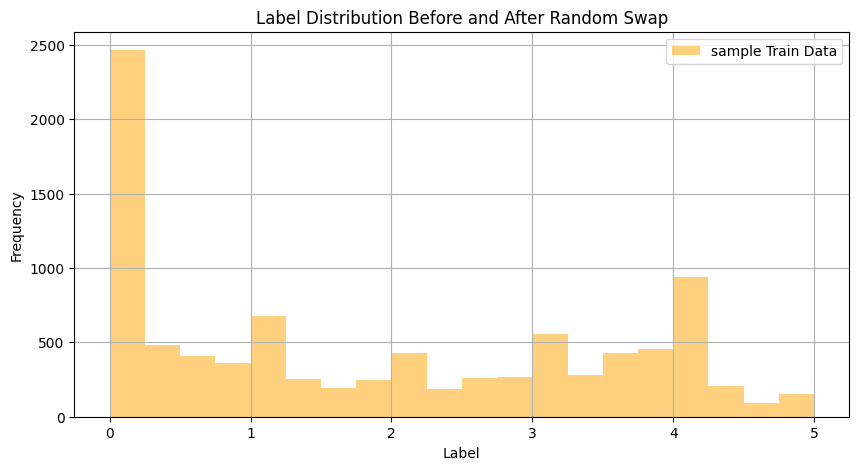

In [ ]:
# 라벨 분포 시각화
plt.figure(figsize=(10, 5))
data_train['label'].hist(alpha=0.5, color='orange', label='sample Train Data', bins=20)
plt.legend()
plt.title('Label Distribution Before and After Random Swap')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()


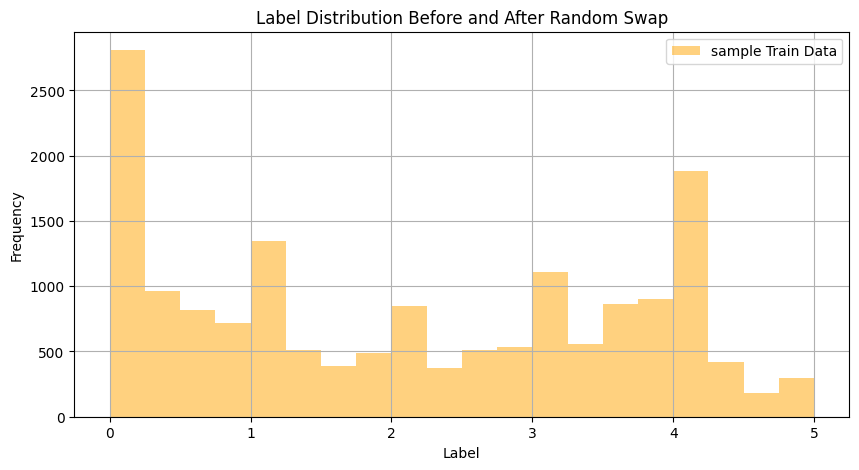

In [ ]:
# 라벨 분포 시각화
plt.figure(figsize=(10, 5))
combined_data['label'].hist(alpha=0.5, color='orange', label='sample Train Data', bins=20)
plt.legend()
plt.title('Label Distribution Before and After Random Swap')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
